In [1]:
# Import Deps
import os
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import tensorflow as tf
import logging
from tqdm import tqdm

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Import Locals
from src.utils.consts import TF_RECORD_DATASET, MODELS_PATH, TF_BUFFER_SIZE, NUM_CLASSES
from src.model.tensorflow_utils import load_and_split_dataset, apply_augmentation_to_dataset, optimize_dataset
from src.model.tensorflow_utils import setup_logger, setup_training_logger, setup_weight_monitor, setup_metrics_logger, get_metrics
from src.model.tensorflow_utils import calculate_class_weights, show_class_weights
from src.model.tensorflow_utils import show_augmented_sample, show_sample_record

# Input Data
DATASET_SIZE = 102697
model_name = "Simplified_DensNet_v1"
tfrecord_path = f"{TF_RECORD_DATASET}/chest_xray_data.tfrecord"

In [2]:
# Load Dataset
batch_size = 32
shuffle_buffer_size = 1000
tfrecord_buffer_size = TF_BUFFER_SIZE
dataset_size = DATASET_SIZE

train_ds, val_ds, test_ds = load_and_split_dataset(tfrecord_path, shuffle_buffer_size, tfrecord_buffer_size, dataset_size)

In [3]:
show_sample_record(train_ds)


One-hot encoded labels:
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]


In [4]:
logger = setup_logger()
training_logger = setup_training_logger(logger, batch_size, 100)
weight_monitor = setup_weight_monitor(logger)
metrics_logger = setup_metrics_logger(MODELS_PATH, model_name)

In [5]:
# Compile Model 
from src.model.tensorflow_densnet_basic import build_densenet121
metrics = get_metrics()

# Model V1
binary_loss = BinaryCrossentropy(label_smoothing=0.01)
# Model V2
focal_loss  = BinaryFocalCrossentropy(gamma=2.0, alpha=0.25, from_logits=False, label_smoothing=0.01)

model = build_densenet121(NUM_CLASSES)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=binary_loss, metrics=metrics)

In [6]:
# Optimize Dataset for rare clasess
class_weights = calculate_class_weights(train_ds, NUM_CLASSES)
show_class_weights(class_weights)

Class Weights:
Class 0: 0.60
Class 1: 2.49
Class 2: 1.49
Class 3: 3.02
Class 4: 0.52
Class 5: 2.68
Class 6: 4.10
Class 7: 28.53
Class 8: 0.35
Class 9: 1.18
Class 10: 0.13
Class 11: 1.09
Class 12: 2.04
Class 13: 5.06
Class 14: 1.28


In [7]:
# Trenowanie modelu
steps_per_epoch = 71887 or len(list(train_ds))
steps_per_epoch = int(steps_per_epoch / 32)

validation_steps = 15404 or len(list(val_ds))
validation_steps = int(validation_steps / 32)

train_ds = apply_augmentation_to_dataset(train_ds)
train_ds = optimize_dataset(train_ds, batch_size)
val_ds = optimize_dataset(val_ds, batch_size)
test_ds = optimize_dataset(test_ds, batch_size)

model_path = f"{MODELS_PATH}/{model_name}.keras"
reduce_lr = ReduceLROnPlateau(monitor="val_f1_score", factor=0.5,  patience=3, min_lr=1e-6, mode="max", verbose=1)
checkpoint = ModelCheckpoint(model_path, monitor="val_f1_score", save_best_only=True, mode="max")

history = model.fit(
    train_ds.repeat(),
    validation_data=val_ds.repeat(),
    class_weight=class_weights,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, reduce_lr, training_logger, weight_monitor, metrics_logger]
)

2025-02-22 22:04:16 - INFO - 
=== Training Started ===

2025-02-22 22:04:16 - INFO - Batch Size: 32
2025-02-22 22:04:16 - INFO - Optimizer: Adam
2025-02-22 22:04:16 - INFO - 

2025-02-22 22:04:16 - INFO - 
=== Starting Epoch 1 ===

2025-02-22 22:04:17 - INFO - 
Epoch 0 Weight Stats:
2025-02-22 22:04:17 - INFO - Mean: 0.000
2025-02-22 22:04:17 - INFO - Std: 0.024
2025-02-22 22:04:17 - INFO - Max: 0.265


Epoch 1/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.8835 - auc: 0.5342 - f1_score: 0.0558 - loss: 0.5356 - precision: 0.1095 - recall: 0.0435  

2025-02-22 22:15:55 - INFO - 
=== Epoch 1 Summary ===
2025-02-22 22:15:55 - INFO - Time: 699.26s
2025-02-22 22:15:55 - INFO - Training   - accuracy: 0.9040 - auc: 0.5498 - f1_score: 0.0337 - loss: 0.4252 - precision: 0.1244 - recall: 0.0203 - learning_rate: 0.0001
2025-02-22 22:15:55 - INFO - Validation - accuracy: 0.9138 - auc: 0.6287 - f1_score: 0.0066 - loss: 0.2559 - precision: 0.3030 - recall: 0.0035
2025-02-22 22:15:55 - INFO - ==================================================

2025-02-22 22:15:56 - INFO - 
Epoch 0 Weight Stats:
2025-02-22 22:15:56 - INFO - Mean: -0.000
2025-02-22 22:15:56 - INFO - Std: 0.014
2025-02-22 22:15:56 - INFO - Max: 0.265


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 699s 304ms/step - accuracy: 0.8835 - auc: 0.5342 - f1_score: 0.0558 - loss: 0.5356 - precision: 0.1095 - recall: 0.0435 - val_accuracy: 0.9138 - val_auc: 0.6287 - val_f1_score: 0.0066 - val_loss: 0.2559 - val_precision: 0.3030 - val_recall: 0.0035 - learning_rate: 1.0000e-04


2025-02-22 22:15:56 - INFO - 
=== Starting Epoch 2 ===

2025-02-22 22:15:56 - INFO - 
Epoch 1 Weight Stats:
2025-02-22 22:15:56 - INFO - Mean: -0.000
2025-02-22 22:15:56 - INFO - Std: 0.014
2025-02-22 22:15:56 - INFO - Max: 0.265


Epoch 2/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9122 - auc: 0.5716 - f1_score: 0.0124 - loss: 0.1863 - precision: 0.1694 - recall: 0.0068         

2025-02-22 23:27:47 - INFO - 
=== Epoch 2 Summary ===
2025-02-22 23:27:47 - INFO - Time: 4311.13s
2025-02-22 23:27:47 - INFO - Training   - accuracy: 0.9123 - auc: 0.5789 - f1_score: 0.0123 - loss: 0.1516 - precision: 0.1744 - recall: 0.0068 - learning_rate: 0.0001
2025-02-22 23:27:47 - INFO - Validation - accuracy: 0.9104 - auc: 0.5932 - f1_score: 0.0217 - loss: 0.1259 - precision: 0.1940 - recall: 0.0139
2025-02-22 23:27:47 - INFO - ==================================================

2025-02-22 23:27:50 - INFO - 
Epoch 1 Weight Stats:
2025-02-22 23:27:50 - INFO - Mean: -0.000
2025-02-22 23:27:50 - INFO - Std: 0.007
2025-02-22 23:27:50 - INFO - Max: 0.261


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 4314s 2s/step - accuracy: 0.9122 - auc: 0.5716 - f1_score: 0.0124 - loss: 0.1863 - precision: 0.1694 - recall: 0.0068 - val_accuracy: 0.9104 - val_auc: 0.5932 - val_f1_score: 0.0217 - val_loss: 0.1259 - val_precision: 0.1940 - val_recall: 0.0139 - learning_rate: 1.0000e-04


2025-02-22 23:27:51 - INFO - 
=== Starting Epoch 3 ===

2025-02-22 23:27:54 - INFO - 
Epoch 2 Weight Stats:
2025-02-22 23:27:54 - INFO - Mean: -0.000
2025-02-22 23:27:54 - INFO - Std: 0.007
2025-02-22 23:27:54 - INFO - Max: 0.261


Epoch 3/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9129 - auc: 0.5752 - f1_score: 0.0104 - loss: 0.0931 - precision: 0.1889 - recall: 0.0056     

2025-02-23 00:47:39 - INFO - 
=== Epoch 3 Summary ===
2025-02-23 00:47:39 - INFO - Time: 4788.39s
2025-02-23 00:47:39 - INFO - Training   - accuracy: 0.9129 - auc: 0.5828 - f1_score: 0.0098 - loss: 0.0863 - precision: 0.1851 - recall: 0.0053 - learning_rate: 0.0001
2025-02-23 00:47:39 - INFO - Validation - accuracy: 0.9128 - auc: 0.6224 - f1_score: 0.0151 - loss: 0.1020 - precision: 0.2647 - recall: 0.0091
2025-02-23 00:47:39 - INFO - ==================================================

2025-02-23 00:47:40 - INFO - 
Epoch 2 Weight Stats:
2025-02-23 00:47:40 - INFO - Mean: -0.000
2025-02-23 00:47:40 - INFO - Std: 0.004
2025-02-23 00:47:40 - INFO - Max: 0.259


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 4786s 2s/step - accuracy: 0.9129 - auc: 0.5752 - f1_score: 0.0104 - loss: 0.0931 - precision: 0.1889 - recall: 0.0056 - val_accuracy: 0.9128 - val_auc: 0.6224 - val_f1_score: 0.0151 - val_loss: 0.1020 - val_precision: 0.2647 - val_recall: 0.0091 - learning_rate: 1.0000e-04


2025-02-23 00:47:40 - INFO - 
=== Starting Epoch 4 ===

2025-02-23 00:47:40 - INFO - 
Epoch 3 Weight Stats:
2025-02-23 00:47:40 - INFO - Mean: -0.000
2025-02-23 00:47:40 - INFO - Std: 0.004
2025-02-23 00:47:40 - INFO - Max: 0.259


Epoch 4/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9132 - auc: 0.5846 - f1_score: 0.0074 - loss: 0.0717 - precision: 0.1678 - recall: 0.0039         

2025-02-23 01:51:21 - INFO - 
=== Epoch 4 Summary ===
2025-02-23 01:51:21 - INFO - Time: 3821.17s
2025-02-23 01:51:21 - INFO - Training   - accuracy: 0.9131 - auc: 0.5888 - f1_score: 0.0079 - loss: 0.0700 - precision: 0.1736 - recall: 0.0042 - learning_rate: 0.0001
2025-02-23 01:51:21 - INFO - Validation - accuracy: 0.9141 - auc: 0.6297 - f1_score: 0.0006 - loss: 0.0917 - precision: 0.2308 - recall: 0.0003
2025-02-23 01:51:21 - INFO - ==================================================

2025-02-23 01:51:23 - INFO - 
Epoch 3 Weight Stats:
2025-02-23 01:51:23 - INFO - Mean: -0.000
2025-02-23 01:51:23 - INFO - Std: 0.003
2025-02-23 01:51:23 - INFO - Max: 0.255


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 3823s 2s/step - accuracy: 0.9132 - auc: 0.5846 - f1_score: 0.0074 - loss: 0.0717 - precision: 0.1678 - recall: 0.0039 - val_accuracy: 0.9141 - val_auc: 0.6297 - val_f1_score: 5.9907e-04 - val_loss: 0.0917 - val_precision: 0.2308 - val_recall: 3.0282e-04 - learning_rate: 1.0000e-04


2025-02-23 01:51:23 - INFO - 
=== Starting Epoch 5 ===

2025-02-23 01:51:25 - INFO - 
Epoch 4 Weight Stats:
2025-02-23 01:51:25 - INFO - Mean: -0.000
2025-02-23 01:51:25 - INFO - Std: 0.003
2025-02-23 01:51:25 - INFO - Max: 0.255


Epoch 5/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9134 - auc: 0.5873 - f1_score: 0.0075 - loss: 0.0650 - precision: 0.1918 - recall: 0.0040      
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


2025-02-23 03:48:00 - INFO - 
=== Epoch 5 Summary ===
2025-02-23 03:48:00 - INFO - Time: 6997.07s
2025-02-23 03:48:00 - INFO - Training   - accuracy: 0.9133 - auc: 0.5905 - f1_score: 0.0074 - loss: 0.0649 - precision: 0.1832 - recall: 0.0039 - learning_rate: 0.0001
2025-02-23 03:48:00 - INFO - Validation - accuracy: 0.9137 - auc: 0.6233 - f1_score: 0.0111 - loss: 0.0873 - precision: 0.3516 - recall: 0.0062
2025-02-23 03:48:00 - INFO - ==================================================

2025-02-23 03:48:02 - INFO - 
Epoch 4 Weight Stats:
2025-02-23 03:48:02 - INFO - Mean: -0.000
2025-02-23 03:48:02 - INFO - Std: 0.003
2025-02-23 03:48:02 - INFO - Max: 0.253


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 6997s 3s/step - accuracy: 0.9134 - auc: 0.5873 - f1_score: 0.0075 - loss: 0.0650 - precision: 0.1918 - recall: 0.0040 - val_accuracy: 0.9137 - val_auc: 0.6233 - val_f1_score: 0.0111 - val_loss: 0.0873 - val_precision: 0.3516 - val_recall: 0.0062 - learning_rate: 1.0000e-04


2025-02-23 03:48:02 - INFO - 
=== Starting Epoch 6 ===

2025-02-23 03:48:04 - INFO - 
Epoch 5 Weight Stats:
2025-02-23 03:48:04 - INFO - Mean: -0.000
2025-02-23 03:48:04 - INFO - Std: 0.003
2025-02-23 03:48:04 - INFO - Max: 0.253


Epoch 6/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9138 - auc: 0.6073 - f1_score: 0.0051 - loss: 0.0613 - precision: 0.2030 - recall: 0.0027      

2025-02-23 04:54:16 - INFO - 
=== Epoch 6 Summary ===
2025-02-23 04:54:16 - INFO - Time: 3973.66s
2025-02-23 04:54:16 - INFO - Training   - accuracy: 0.9137 - auc: 0.6134 - f1_score: 0.0054 - loss: 0.0612 - precision: 0.2009 - recall: 0.0029 - learning_rate: 0.0000
2025-02-23 04:54:16 - INFO - Validation - accuracy: 0.9139 - auc: 0.6457 - f1_score: 0.0037 - loss: 0.0824 - precision: 0.2836 - recall: 0.0019
2025-02-23 04:54:16 - INFO - ==================================================

2025-02-23 04:54:18 - INFO - 
Epoch 5 Weight Stats:
2025-02-23 04:54:18 - INFO - Mean: -0.000
2025-02-23 04:54:19 - INFO - Std: 0.003
2025-02-23 04:54:19 - INFO - Max: 0.249


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 3975s 2s/step - accuracy: 0.9138 - auc: 0.6073 - f1_score: 0.0051 - loss: 0.0613 - precision: 0.2030 - recall: 0.0027 - val_accuracy: 0.9139 - val_auc: 0.6457 - val_f1_score: 0.0037 - val_loss: 0.0824 - val_precision: 0.2836 - val_recall: 0.0019 - learning_rate: 5.0000e-05


2025-02-23 04:54:19 - INFO - 
=== Starting Epoch 7 ===

2025-02-23 04:54:21 - INFO - 
Epoch 6 Weight Stats:
2025-02-23 04:54:21 - INFO - Mean: -0.000
2025-02-23 04:54:21 - INFO - Std: 0.003
2025-02-23 04:54:21 - INFO - Max: 0.249


Epoch 7/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9139 - auc: 0.6110 - f1_score: 0.0058 - loss: 0.0601 - precision: 0.2258 - recall: 0.0031         

2025-02-23 06:39:59 - INFO - 
=== Epoch 7 Summary ===
2025-02-23 06:39:59 - INFO - Time: 6340.10s
2025-02-23 06:39:59 - INFO - Training   - accuracy: 0.9137 - auc: 0.6173 - f1_score: 0.0055 - loss: 0.0603 - precision: 0.2026 - recall: 0.0029 - learning_rate: 0.0000
2025-02-23 06:39:59 - INFO - Validation - accuracy: 0.9140 - auc: 0.6577 - f1_score: 0.0021 - loss: 0.0794 - precision: 0.2692 - recall: 0.0011
2025-02-23 06:39:59 - INFO - ==================================================

2025-02-23 06:40:01 - INFO - 
Epoch 6 Weight Stats:
2025-02-23 06:40:01 - INFO - Mean: -0.000
2025-02-23 06:40:01 - INFO - Std: 0.002
2025-02-23 06:40:01 - INFO - Max: 0.249


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 6340s 3s/step - accuracy: 0.9139 - auc: 0.6110 - f1_score: 0.0058 - loss: 0.0601 - precision: 0.2258 - recall: 0.0031 - val_accuracy: 0.9140 - val_auc: 0.6577 - val_f1_score: 0.0021 - val_loss: 0.0794 - val_precision: 0.2692 - val_recall: 0.0011 - learning_rate: 5.0000e-05


2025-02-23 06:40:01 - INFO - 
=== Starting Epoch 8 ===

2025-02-23 06:40:02 - INFO - 
Epoch 7 Weight Stats:
2025-02-23 06:40:02 - INFO - Mean: -0.000
2025-02-23 06:40:02 - INFO - Std: 0.002
2025-02-23 06:40:02 - INFO - Max: 0.249


Epoch 8/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9138 - auc: 0.6210 - f1_score: 0.0045 - loss: 0.0587 - precision: 0.1956 - recall: 0.0023      
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


2025-02-23 08:11:45 - INFO - 
=== Epoch 8 Summary ===
2025-02-23 08:11:45 - INFO - Time: 5503.98s
2025-02-23 08:11:45 - INFO - Training   - accuracy: 0.9137 - auc: 0.6241 - f1_score: 0.0057 - loss: 0.0591 - precision: 0.2107 - recall: 0.0030 - learning_rate: 0.0000
2025-02-23 08:11:45 - INFO - Validation - accuracy: 0.9140 - auc: 0.6511 - f1_score: 0.0044 - loss: 0.0804 - precision: 0.3333 - recall: 0.0023
2025-02-23 08:11:45 - INFO - ==================================================

2025-02-23 08:11:47 - INFO - 
Epoch 7 Weight Stats:
2025-02-23 08:11:47 - INFO - Mean: -0.000
2025-02-23 08:11:47 - INFO - Std: 0.002
2025-02-23 08:11:47 - INFO - Max: 0.248


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 5505s 2s/step - accuracy: 0.9138 - auc: 0.6210 - f1_score: 0.0045 - loss: 0.0587 - precision: 0.1956 - recall: 0.0023 - val_accuracy: 0.9140 - val_auc: 0.6511 - val_f1_score: 0.0044 - val_loss: 0.0804 - val_precision: 0.3333 - val_recall: 0.0023 - learning_rate: 5.0000e-05


2025-02-23 08:11:47 - INFO - 
=== Starting Epoch 9 ===

2025-02-23 08:11:48 - INFO - 
Epoch 8 Weight Stats:
2025-02-23 08:11:48 - INFO - Mean: -0.000
2025-02-23 08:11:48 - INFO - Std: 0.002
2025-02-23 08:11:48 - INFO - Max: 0.248


Epoch 9/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9139 - auc: 0.6352 - f1_score: 0.0060 - loss: 0.0576 - precision: 0.2347 - recall: 0.0032      

2025-02-23 08:56:53 - INFO - 
=== Epoch 9 Summary ===
2025-02-23 08:56:53 - INFO - Time: 2706.41s
2025-02-23 08:56:53 - INFO - Training   - accuracy: 0.9138 - auc: 0.6448 - f1_score: 0.0060 - loss: 0.0578 - precision: 0.2331 - recall: 0.0032 - learning_rate: 0.0000
2025-02-23 08:56:53 - INFO - Validation - accuracy: 0.9141 - auc: 0.6773 - f1_score: 0.0011 - loss: 0.0784 - precision: 0.2245 - recall: 0.0006
2025-02-23 08:56:53 - INFO - ==================================================

2025-02-23 08:56:56 - INFO - 
Epoch 8 Weight Stats:
2025-02-23 08:56:56 - INFO - Mean: -0.000
2025-02-23 08:56:56 - INFO - Std: 0.002
2025-02-23 08:56:56 - INFO - Max: 0.247


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 2708s 1s/step - accuracy: 0.9139 - auc: 0.6352 - f1_score: 0.0060 - loss: 0.0576 - precision: 0.2347 - recall: 0.0032 - val_accuracy: 0.9141 - val_auc: 0.6773 - val_f1_score: 0.0011 - val_loss: 0.0784 - val_precision: 0.2245 - val_recall: 5.5516e-04 - learning_rate: 2.5000e-05


2025-02-23 08:56:56 - INFO - 
=== Starting Epoch 10 ===

2025-02-23 08:57:00 - INFO - 
Epoch 9 Weight Stats:
2025-02-23 08:57:00 - INFO - Mean: -0.000
2025-02-23 08:57:00 - INFO - Std: 0.002
2025-02-23 08:57:00 - INFO - Max: 0.247


Epoch 10/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9139 - auc: 0.6498 - f1_score: 0.0072 - loss: 0.0569 - precision: 0.2754 - recall: 0.0037        

2025-02-23 10:10:48 - INFO - 
=== Epoch 10 Summary ===
2025-02-23 10:10:48 - INFO - Time: 4431.45s
2025-02-23 10:10:48 - INFO - Training   - accuracy: 0.9138 - auc: 0.6547 - f1_score: 0.0068 - loss: 0.0572 - precision: 0.2405 - recall: 0.0036 - learning_rate: 0.0000
2025-02-23 10:10:48 - INFO - Validation - accuracy: 0.9139 - auc: 0.6881 - f1_score: 0.0066 - loss: 0.0783 - precision: 0.3560 - recall: 0.0034
2025-02-23 10:10:48 - INFO - ==================================================

2025-02-23 10:10:48 - INFO - 
Epoch 9 Weight Stats:
2025-02-23 10:10:48 - INFO - Mean: -0.000
2025-02-23 10:10:48 - INFO - Std: 0.002
2025-02-23 10:10:48 - INFO - Max: 0.245


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 4429s 2s/step - accuracy: 0.9139 - auc: 0.6498 - f1_score: 0.0072 - loss: 0.0569 - precision: 0.2754 - recall: 0.0037 - val_accuracy: 0.9139 - val_auc: 0.6881 - val_f1_score: 0.0066 - val_loss: 0.0783 - val_precision: 0.3560 - val_recall: 0.0034 - learning_rate: 2.5000e-05


2025-02-23 10:10:48 - INFO - 
=== Starting Epoch 11 ===

2025-02-23 10:10:49 - INFO - 
Epoch 10 Weight Stats:
2025-02-23 10:10:49 - INFO - Mean: -0.000
2025-02-23 10:10:49 - INFO - Std: 0.002
2025-02-23 10:10:49 - INFO - Max: 0.245


Epoch 11/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9137 - auc: 0.6545 - f1_score: 0.0068 - loss: 0.0567 - precision: 0.2279 - recall: 0.0036      
Epoch 11: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


2025-02-23 10:21:46 - INFO - 
=== Epoch 11 Summary ===
2025-02-23 10:21:46 - INFO - Time: 657.20s
2025-02-23 10:21:46 - INFO - Training   - accuracy: 0.9136 - auc: 0.6626 - f1_score: 0.0082 - loss: 0.0568 - precision: 0.2368 - recall: 0.0044 - learning_rate: 0.0000
2025-02-23 10:21:46 - INFO - Validation - accuracy: 0.9135 - auc: 0.6972 - f1_score: 0.0035 - loss: 0.0760 - precision: 0.1709 - recall: 0.0020
2025-02-23 10:21:46 - INFO - ==================================================

2025-02-23 10:21:46 - INFO - 
Epoch 10 Weight Stats:
2025-02-23 10:21:46 - INFO - Mean: -0.000
2025-02-23 10:21:46 - INFO - Std: 0.002
2025-02-23 10:21:46 - INFO - Max: 0.244


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 657s 293ms/step - accuracy: 0.9137 - auc: 0.6545 - f1_score: 0.0068 - loss: 0.0567 - precision: 0.2279 - recall: 0.0036 - val_accuracy: 0.9135 - val_auc: 0.6972 - val_f1_score: 0.0035 - val_loss: 0.0760 - val_precision: 0.1709 - val_recall: 0.0020 - learning_rate: 2.5000e-05


2025-02-23 10:21:46 - INFO - 
=== Starting Epoch 12 ===

2025-02-23 10:21:46 - INFO - 
Epoch 11 Weight Stats:
2025-02-23 10:21:46 - INFO - Mean: -0.000
2025-02-23 10:21:46 - INFO - Std: 0.002
2025-02-23 10:21:46 - INFO - Max: 0.244


Epoch 12/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9135 - auc: 0.6782 - f1_score: 0.0105 - loss: 0.0554 - precision: 0.2461 - recall: 0.0056      

2025-02-23 10:32:50 - INFO - 
=== Epoch 12 Summary ===
2025-02-23 10:32:50 - INFO - Time: 663.72s
2025-02-23 10:32:50 - INFO - Training   - accuracy: 0.9133 - auc: 0.6840 - f1_score: 0.0128 - loss: 0.0556 - precision: 0.2554 - recall: 0.0070 - learning_rate: 0.0000
2025-02-23 10:32:50 - INFO - Validation - accuracy: 0.9121 - auc: 0.7060 - f1_score: 0.0167 - loss: 0.0771 - precision: 0.2250 - recall: 0.0101
2025-02-23 10:32:50 - INFO - ==================================================

2025-02-23 10:32:50 - INFO - 
Epoch 11 Weight Stats:
2025-02-23 10:32:50 - INFO - Mean: -0.000
2025-02-23 10:32:50 - INFO - Std: 0.002
2025-02-23 10:32:50 - INFO - Max: 0.243


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 664s 295ms/step - accuracy: 0.9135 - auc: 0.6782 - f1_score: 0.0105 - loss: 0.0554 - precision: 0.2461 - recall: 0.0056 - val_accuracy: 0.9121 - val_auc: 0.7060 - val_f1_score: 0.0167 - val_loss: 0.0771 - val_precision: 0.2250 - val_recall: 0.0101 - learning_rate: 1.2500e-05


2025-02-23 10:32:50 - INFO - 
=== Starting Epoch 13 ===

2025-02-23 10:32:51 - INFO - 
Epoch 12 Weight Stats:
2025-02-23 10:32:51 - INFO - Mean: -0.000
2025-02-23 10:32:51 - INFO - Std: 0.002
2025-02-23 10:32:51 - INFO - Max: 0.243


Epoch 13/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9132 - auc: 0.6878 - f1_score: 0.0152 - loss: 0.0549 - precision: 0.2725 - recall: 0.0085      

2025-02-23 10:43:55 - INFO - 
=== Epoch 13 Summary ===
2025-02-23 10:43:55 - INFO - Time: 664.80s
2025-02-23 10:43:55 - INFO - Training   - accuracy: 0.9129 - auc: 0.6946 - f1_score: 0.0177 - loss: 0.0549 - precision: 0.2685 - recall: 0.0102 - learning_rate: 0.0000
2025-02-23 10:43:55 - INFO - Validation - accuracy: 0.9107 - auc: 0.7173 - f1_score: 0.0242 - loss: 0.0756 - precision: 0.2227 - recall: 0.0163
2025-02-23 10:43:55 - INFO - ==================================================

2025-02-23 10:43:56 - INFO - 
Epoch 12 Weight Stats:
2025-02-23 10:43:56 - INFO - Mean: -0.000
2025-02-23 10:43:56 - INFO - Std: 0.002
2025-02-23 10:43:56 - INFO - Max: 0.243


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 665s 296ms/step - accuracy: 0.9132 - auc: 0.6878 - f1_score: 0.0152 - loss: 0.0549 - precision: 0.2725 - recall: 0.0085 - val_accuracy: 0.9107 - val_auc: 0.7173 - val_f1_score: 0.0242 - val_loss: 0.0756 - val_precision: 0.2227 - val_recall: 0.0163 - learning_rate: 1.2500e-05


2025-02-23 10:43:56 - INFO - 
=== Starting Epoch 14 ===

2025-02-23 10:43:56 - INFO - 
Epoch 13 Weight Stats:
2025-02-23 10:43:56 - INFO - Mean: -0.000
2025-02-23 10:43:56 - INFO - Std: 0.002
2025-02-23 10:43:56 - INFO - Max: 0.243


Epoch 14/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9127 - auc: 0.6986 - f1_score: 0.0214 - loss: 0.0541 - precision: 0.2803 - recall: 0.0128  

2025-02-23 10:55:01 - INFO - 
=== Epoch 14 Summary ===
2025-02-23 10:55:01 - INFO - Time: 665.74s
2025-02-23 10:55:01 - INFO - Training   - accuracy: 0.9125 - auc: 0.7056 - f1_score: 0.0237 - loss: 0.0543 - precision: 0.2772 - recall: 0.0144 - learning_rate: 0.0000
2025-02-23 10:55:01 - INFO - Validation - accuracy: 0.9119 - auc: 0.7222 - f1_score: 0.0309 - loss: 0.0754 - precision: 0.2966 - recall: 0.0191
2025-02-23 10:55:01 - INFO - ==================================================

2025-02-23 10:55:02 - INFO - 
Epoch 13 Weight Stats:
2025-02-23 10:55:02 - INFO - Mean: -0.000
2025-02-23 10:55:02 - INFO - Std: 0.002
2025-02-23 10:55:02 - INFO - Max: 0.243


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 666s 296ms/step - accuracy: 0.9127 - auc: 0.6986 - f1_score: 0.0214 - loss: 0.0541 - precision: 0.2803 - recall: 0.0128 - val_accuracy: 0.9119 - val_auc: 0.7222 - val_f1_score: 0.0309 - val_loss: 0.0754 - val_precision: 0.2966 - val_recall: 0.0191 - learning_rate: 1.2500e-05


2025-02-23 10:55:02 - INFO - 
=== Starting Epoch 15 ===

2025-02-23 10:55:02 - INFO - 
Epoch 14 Weight Stats:
2025-02-23 10:55:02 - INFO - Mean: -0.000
2025-02-23 10:55:02 - INFO - Std: 0.002
2025-02-23 10:55:02 - INFO - Max: 0.243


Epoch 15/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9125 - auc: 0.7061 - f1_score: 0.0285 - loss: 0.0535 - precision: 0.3011 - recall: 0.0176  

2025-02-23 11:06:07 - INFO - 
=== Epoch 15 Summary ===
2025-02-23 11:06:07 - INFO - Time: 665.77s
2025-02-23 11:06:07 - INFO - Training   - accuracy: 0.9121 - auc: 0.7137 - f1_score: 0.0316 - loss: 0.0537 - precision: 0.2982 - recall: 0.0199 - learning_rate: 0.0000
2025-02-23 11:06:07 - INFO - Validation - accuracy: 0.9081 - auc: 0.7220 - f1_score: 0.0389 - loss: 0.0797 - precision: 0.2003 - recall: 0.0238
2025-02-23 11:06:07 - INFO - ==================================================

2025-02-23 11:06:08 - INFO - 
Epoch 14 Weight Stats:
2025-02-23 11:06:08 - INFO - Mean: -0.000
2025-02-23 11:06:08 - INFO - Std: 0.002
2025-02-23 11:06:08 - INFO - Max: 0.242


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 666s 296ms/step - accuracy: 0.9125 - auc: 0.7061 - f1_score: 0.0285 - loss: 0.0535 - precision: 0.3011 - recall: 0.0176 - val_accuracy: 0.9081 - val_auc: 0.7220 - val_f1_score: 0.0389 - val_loss: 0.0797 - val_precision: 0.2003 - val_recall: 0.0238 - learning_rate: 1.2500e-05


2025-02-23 11:06:08 - INFO - 
=== Starting Epoch 16 ===

2025-02-23 11:06:08 - INFO - 
Epoch 15 Weight Stats:
2025-02-23 11:06:08 - INFO - Mean: -0.000
2025-02-23 11:06:08 - INFO - Std: 0.002
2025-02-23 11:06:08 - INFO - Max: 0.242


Epoch 16/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9120 - auc: 0.7135 - f1_score: 0.0336 - loss: 0.0528 - precision: 0.3019 - recall: 0.0217      

2025-02-23 11:17:13 - INFO - 
=== Epoch 16 Summary ===
2025-02-23 11:17:13 - INFO - Time: 665.46s
2025-02-23 11:17:13 - INFO - Training   - accuracy: 0.9119 - auc: 0.7187 - f1_score: 0.0378 - loss: 0.0531 - precision: 0.3101 - recall: 0.0244 - learning_rate: 0.0000
2025-02-23 11:17:13 - INFO - Validation - accuracy: 0.9104 - auc: 0.7382 - f1_score: 0.0444 - loss: 0.0737 - precision: 0.2783 - recall: 0.0278
2025-02-23 11:17:13 - INFO - ==================================================

2025-02-23 11:17:14 - INFO - 
Epoch 15 Weight Stats:
2025-02-23 11:17:14 - INFO - Mean: -0.000
2025-02-23 11:17:14 - INFO - Std: 0.002
2025-02-23 11:17:14 - INFO - Max: 0.242


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 665s 296ms/step - accuracy: 0.9120 - auc: 0.7135 - f1_score: 0.0336 - loss: 0.0528 - precision: 0.3019 - recall: 0.0217 - val_accuracy: 0.9104 - val_auc: 0.7382 - val_f1_score: 0.0444 - val_loss: 0.0737 - val_precision: 0.2783 - val_recall: 0.0278 - learning_rate: 1.2500e-05


2025-02-23 11:17:14 - INFO - 
=== Starting Epoch 17 ===

2025-02-23 11:17:14 - INFO - 
Epoch 16 Weight Stats:
2025-02-23 11:17:14 - INFO - Mean: -0.000
2025-02-23 11:17:14 - INFO - Std: 0.002
2025-02-23 11:17:14 - INFO - Max: 0.242


Epoch 17/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9121 - auc: 0.7184 - f1_score: 0.0416 - loss: 0.0523 - precision: 0.3313 - recall: 0.0269  

2025-02-23 11:28:21 - INFO - 
=== Epoch 17 Summary ===
2025-02-23 11:28:21 - INFO - Time: 666.64s
2025-02-23 11:28:21 - INFO - Training   - accuracy: 0.9118 - auc: 0.7251 - f1_score: 0.0444 - loss: 0.0525 - precision: 0.3269 - recall: 0.0290 - learning_rate: 0.0000
2025-02-23 11:28:21 - INFO - Validation - accuracy: 0.9108 - auc: 0.7378 - f1_score: 0.0567 - loss: 0.0727 - precision: 0.3275 - recall: 0.0379
2025-02-23 11:28:21 - INFO - ==================================================

2025-02-23 11:28:21 - INFO - 
Epoch 16 Weight Stats:
2025-02-23 11:28:21 - INFO - Mean: -0.000
2025-02-23 11:28:21 - INFO - Std: 0.002
2025-02-23 11:28:21 - INFO - Max: 0.242


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 667s 297ms/step - accuracy: 0.9121 - auc: 0.7184 - f1_score: 0.0416 - loss: 0.0523 - precision: 0.3313 - recall: 0.0269 - val_accuracy: 0.9108 - val_auc: 0.7378 - val_f1_score: 0.0567 - val_loss: 0.0727 - val_precision: 0.3275 - val_recall: 0.0379 - learning_rate: 1.2500e-05


2025-02-23 11:28:21 - INFO - 
=== Starting Epoch 18 ===

2025-02-23 11:28:21 - INFO - 
Epoch 17 Weight Stats:
2025-02-23 11:28:21 - INFO - Mean: -0.000
2025-02-23 11:28:21 - INFO - Std: 0.002
2025-02-23 11:28:21 - INFO - Max: 0.242


Epoch 18/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9119 - auc: 0.7249 - f1_score: 0.0480 - loss: 0.0519 - precision: 0.3404 - recall: 0.0313  

2025-02-23 11:40:01 - INFO - 
=== Epoch 18 Summary ===
2025-02-23 11:40:01 - INFO - Time: 700.19s
2025-02-23 11:40:01 - INFO - Training   - accuracy: 0.9117 - auc: 0.7298 - f1_score: 0.0525 - loss: 0.0520 - precision: 0.3432 - recall: 0.0346 - learning_rate: 0.0000
2025-02-23 11:40:01 - INFO - Validation - accuracy: 0.9040 - auc: 0.7276 - f1_score: 0.0642 - loss: 0.0806 - precision: 0.2212 - recall: 0.0471
2025-02-23 11:40:01 - INFO - ==================================================

2025-02-23 11:40:02 - INFO - 
Epoch 17 Weight Stats:
2025-02-23 11:40:02 - INFO - Mean: -0.000
2025-02-23 11:40:02 - INFO - Std: 0.002
2025-02-23 11:40:02 - INFO - Max: 0.242


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 700s 312ms/step - accuracy: 0.9119 - auc: 0.7249 - f1_score: 0.0480 - loss: 0.0519 - precision: 0.3404 - recall: 0.0313 - val_accuracy: 0.9040 - val_auc: 0.7276 - val_f1_score: 0.0642 - val_loss: 0.0806 - val_precision: 0.2212 - val_recall: 0.0471 - learning_rate: 1.2500e-05


2025-02-23 11:40:02 - INFO - 
=== Starting Epoch 19 ===

2025-02-23 11:40:02 - INFO - 
Epoch 18 Weight Stats:
2025-02-23 11:40:02 - INFO - Mean: -0.000
2025-02-23 11:40:02 - INFO - Std: 0.002
2025-02-23 11:40:02 - INFO - Max: 0.242


Epoch 19/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9120 - auc: 0.7302 - f1_score: 0.0599 - loss: 0.0512 - precision: 0.3662 - recall: 0.0393  

2025-02-23 11:51:31 - INFO - 
=== Epoch 19 Summary ===
2025-02-23 11:51:31 - INFO - Time: 688.95s
2025-02-23 11:51:31 - INFO - Training   - accuracy: 0.9119 - auc: 0.7346 - f1_score: 0.0611 - loss: 0.0516 - precision: 0.3653 - recall: 0.0402 - learning_rate: 0.0000
2025-02-23 11:51:31 - INFO - Validation - accuracy: 0.9104 - auc: 0.7400 - f1_score: 0.0624 - loss: 0.0762 - precision: 0.3436 - recall: 0.0479
2025-02-23 11:51:31 - INFO - ==================================================

2025-02-23 11:51:31 - INFO - 
Epoch 18 Weight Stats:
2025-02-23 11:51:31 - INFO - Mean: -0.000
2025-02-23 11:51:31 - INFO - Std: 0.002
2025-02-23 11:51:31 - INFO - Max: 0.241


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 689s 307ms/step - accuracy: 0.9120 - auc: 0.7302 - f1_score: 0.0599 - loss: 0.0512 - precision: 0.3662 - recall: 0.0393 - val_accuracy: 0.9104 - val_auc: 0.7400 - val_f1_score: 0.0624 - val_loss: 0.0762 - val_precision: 0.3436 - val_recall: 0.0479 - learning_rate: 1.2500e-05


2025-02-23 11:51:31 - INFO - 
=== Starting Epoch 20 ===

2025-02-23 11:51:31 - INFO - 
Epoch 19 Weight Stats:
2025-02-23 11:51:31 - INFO - Mean: -0.000
2025-02-23 11:51:31 - INFO - Std: 0.002
2025-02-23 11:51:31 - INFO - Max: 0.241


Epoch 20/20
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9121 - auc: 0.7365 - f1_score: 0.0633 - loss: 0.0510 - precision: 0.3765 - recall: 0.0420  

2025-02-23 12:02:42 - INFO - 
=== Epoch 20 Summary ===
2025-02-23 12:02:42 - INFO - Time: 671.27s
2025-02-23 12:02:42 - INFO - Training   - accuracy: 0.9119 - auc: 0.7406 - f1_score: 0.0656 - loss: 0.0512 - precision: 0.3729 - recall: 0.0436 - learning_rate: 0.0000
2025-02-23 12:02:42 - INFO - Validation - accuracy: 0.9100 - auc: 0.7387 - f1_score: 0.0758 - loss: 0.0796 - precision: 0.3529 - recall: 0.0588
2025-02-23 12:02:42 - INFO - ==================================================

2025-02-23 12:02:43 - INFO - 
Epoch 19 Weight Stats:
2025-02-23 12:02:43 - INFO - Mean: -0.000
2025-02-23 12:02:43 - INFO - Std: 0.002
2025-02-23 12:02:43 - INFO - Max: 0.241


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 671s 299ms/step - accuracy: 0.9121 - auc: 0.7365 - f1_score: 0.0633 - loss: 0.0510 - precision: 0.3765 - recall: 0.0420 - val_accuracy: 0.9100 - val_auc: 0.7387 - val_f1_score: 0.0758 - val_loss: 0.0796 - val_precision: 0.3529 - val_recall: 0.0588 - learning_rate: 1.2500e-05


2025-02-23 12:02:43 - INFO - 
=== Training Completed! ===

2025-02-23 12:02:43 - INFO - Final Metrics: accuracy: 0.9119 - auc: 0.7406 - f1_score: 0.0656 - loss: 0.0512 - precision: 0.3729 - recall: 0.0436 - val_accuracy: 0.9100 - val_auc: 0.7387 - val_f1_score: 0.0758 - val_loss: 0.0796 - val_precision: 0.3529 - val_recall: 0.0588



In [27]:
# Initialize the evaluator
mappings_path = f"{TF_RECORD_DATASET}/label_mappings.csv"
evaluator = ModelEvaluation(
    model=model, 
    model_name=model_name, 
    test_dataset=test_ds,
    label_mappings_path=mappings_path,
    output_dir=MODELS_PATH
)

# Cell 2: Generate predictions and basic metrics
metrics = evaluator.evaluate()


Generating predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━

In [28]:
evaluator.generate_classification_report()


Classification Report:
                    precision    recall  f1-score   support

       Atelectasis       0.40      0.00      0.00      1712
      Cardiomegaly       0.38      0.20      0.26       421
     Consolidation       0.00      0.00      0.00       665
             Edema       0.19      0.22      0.21       337
          Effusion       0.45      0.34      0.38      1985
         Emphysema       0.38      0.03      0.05       374
          Fibrosis       0.09      0.14      0.11       268
            Hernia       0.02      0.17      0.04        30
      Infiltration       0.42      0.08      0.14      2930
              Mass       0.22      0.00      0.00       857
        No Finding       1.00      0.00      0.00      7765
            Nodule       0.00      0.00      0.00       905
Pleural_Thickening       0.00      0.00      0.00       510
         Pneumonia       0.00      0.00      0.00       233
      Pneumothorax       0.52      0.02      0.04       740

         micro

In [29]:
evaluator.plot_confusion_matrices()


Generating combined confusion matrix...
Saved combined confusion matrix to: /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/models/Simplified_DensNet_v2/Simplified_DensNet_v2_combined_confusion_matrix.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


NameError: name 'save_path' is not defined

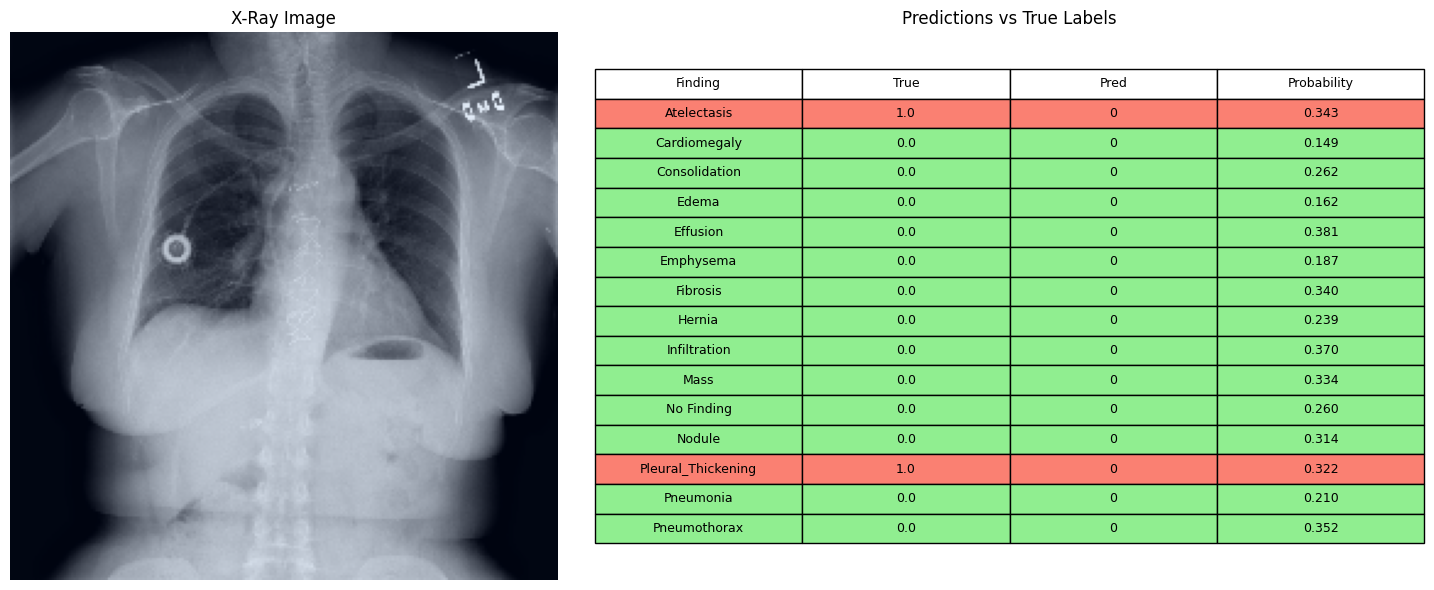

In [31]:
for image, labels in test_ds.take(1):
    if len(image.shape) == 4:
        image = image[0]
        labels = labels[0]
    
    evaluator.visualize_prediction(image=image, true_labels=labels)